In [1]:
import rasterio
from rasterio.plot import show
from rasterio.windows import from_bounds
from rasterio.features import rasterize

import pandas as pd
import geopandas as geopd

import numpy as np
import numpy.ma as ma

import warnings

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcParams["figure.dpi"]  = 400
plt.style.use('dark_background')

In [2]:
max_seg_length = 4000

src_path = f"/home/iiro/Documents/DIWA/data/hydrology_iiro/subwatersheds_{max_seg_length}.gpkg"

dst_path = f"/home/iiro/Documents/DIWA/data/hydrology_iiro/subwatersheds_steepness{max_seg_length}.gpkg"

vector_watershed_path = "/home/iiro/Documents/DIWA/data/hydrology_iiro/watersheds.gpkg"

slope_path = "/media/iiro/T9/gisT7/korkeusmalli_10_m/slope10m.tif"

watersheds = geopd.read_file(vector_watershed_path, layer='watersheds')

In [5]:
test_selection = 150

pbar = tqdm(watersheds.iterrows(), total=len(watersheds))

for i, watershed in pbar:
    if i < test_selection:
        continue

    #Changing to GeoDataFrame
    watershed = geopd.GeoDataFrame(
                    dict(zip(list(watershed.index), list(watershed.values))),
                    crs=watersheds.crs, geometry='geometry', index=[0])

    place_id = watershed.at[0, 'Paikka_Id']

    subwatersheds = geopd.read_file(src_path, layer=f"subwatersheds_{place_id}")

    
    
    
    for j, subwatershed in subwatersheds.iterrows():

        subwatershed = geopd.GeoDataFrame(
                dict(zip(list(subwatershed.index), list(subwatershed.values))),
                crs=subwatersheds.crs, geometry='geometry', index=[0])

        minx = subwatershed.bounds.at[0, 'minx']
        miny = subwatershed.bounds.at[0, 'miny']
        maxx = subwatershed.bounds.at[0, 'maxx']
        maxy = subwatershed.bounds.at[0, 'maxy']
        
        # Opening window of the data from the area of the watershed    
        with rasterio.open(slope_path) as src:
            profile = src.profile
            values = src.read(
                1, window=from_bounds(minx, miny, maxx, maxy, src.transform),
                boundless=True, fill_value=profile['nodata'])
        
        profile['transform'] = rasterio.transform.from_bounds(minx, miny, maxx, maxy, values.shape[1], values.shape[0])
        profile['width'] = values.shape[1]
        profile['height'] = values.shape[0]
    
        # Nodata and waters are excluded so that they don't interfere
        masked_values = ma.masked_values(values, profile['nodata'])

        
        area_mask = rasterize(
                subwatershed['geometry'], (profile['height'], profile['width']),
                dtype=profile['dtype'], transform=profile['transform'], all_touched=True)

        # When calculating the average, unwanted regions must be masked
        clipped_values = ma.masked_where(area_mask == 0, masked_values)
        
        # If the area is completely covered by nodata, the value is set to 0
        warnings.filterwarnings("error") 
        try:
            average = round(clipped_values.sum() / clipped_values.count(), 4)

        except:
            average = 0
            print(f"slope was set to zero for watershed {place_id}, subwatershed {j} because there were no non-masked values")

        subwatersheds.at[j, f"slope"] = average

    subwatersheds.to_file(dst_path, layer=f"subwatersheds_{place_id}", driver="GPKG")
    if i == test_selection:
        break

  0%|          | 0/167 [00:00<?, ?it/s]

<Axes: >

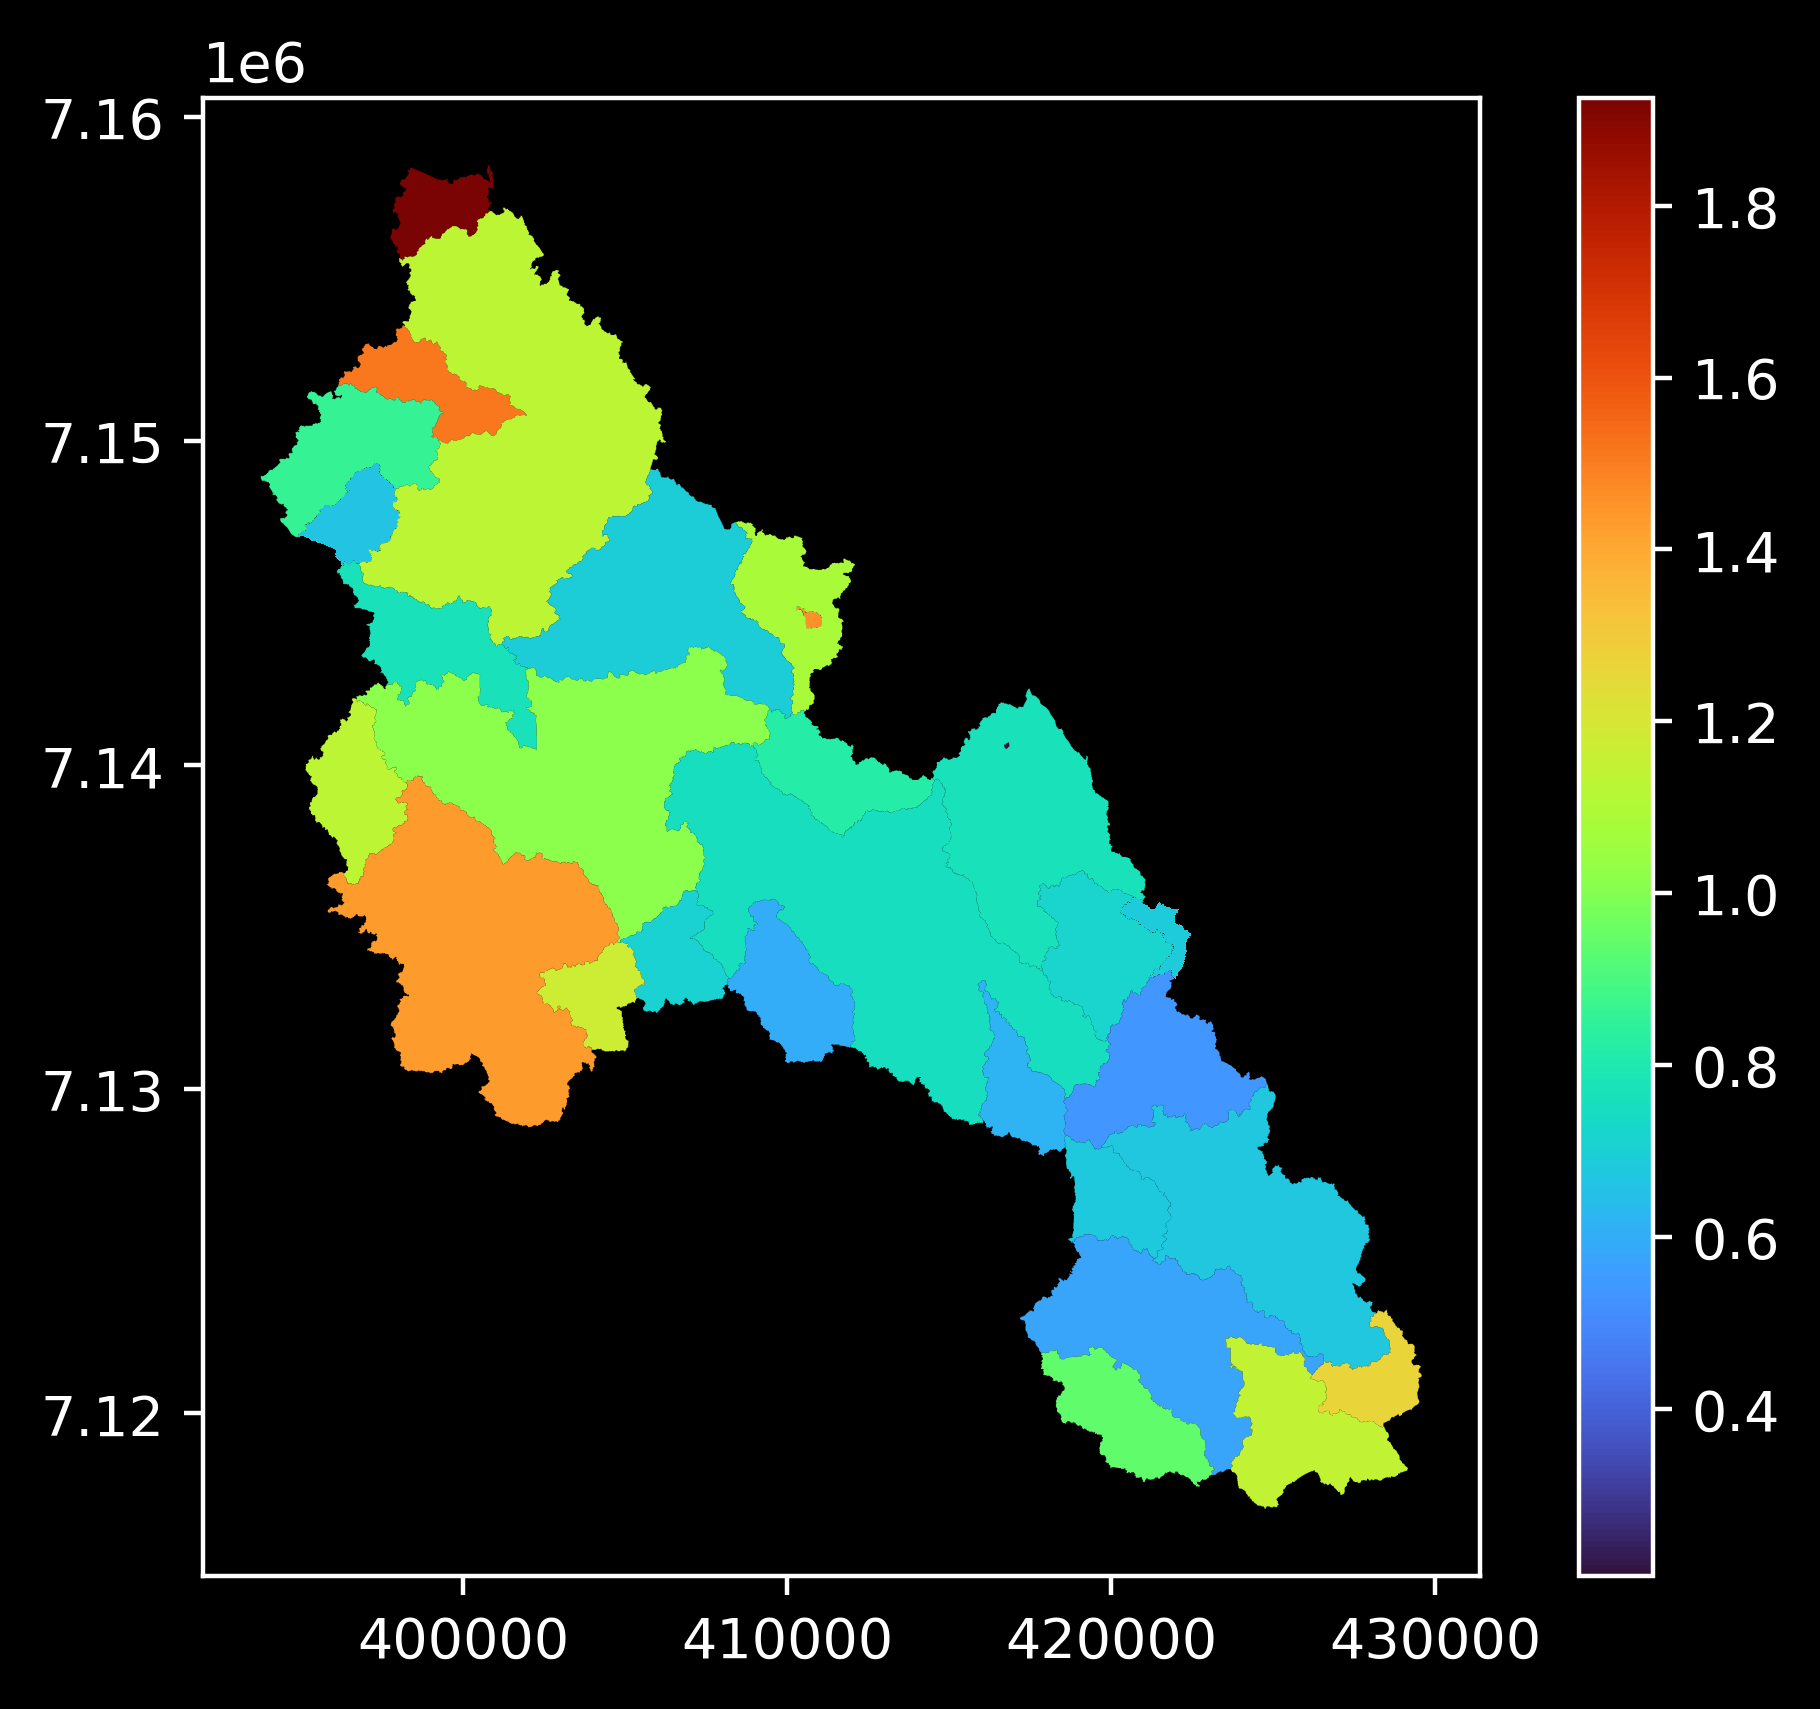

In [4]:
subwatersheds.plot("slope", cmap='turbo', legend=True)